In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm
from math import ceil

In [80]:
data = pd.read_csv('DJIA_data.csv', index_col=0)

close_values = data['Close'].values.reshape(-1, 1)

In [81]:
scaler = MinMaxScaler(feature_range=(0, 1))
close_values_scaled = scaler.fit_transform(close_values)

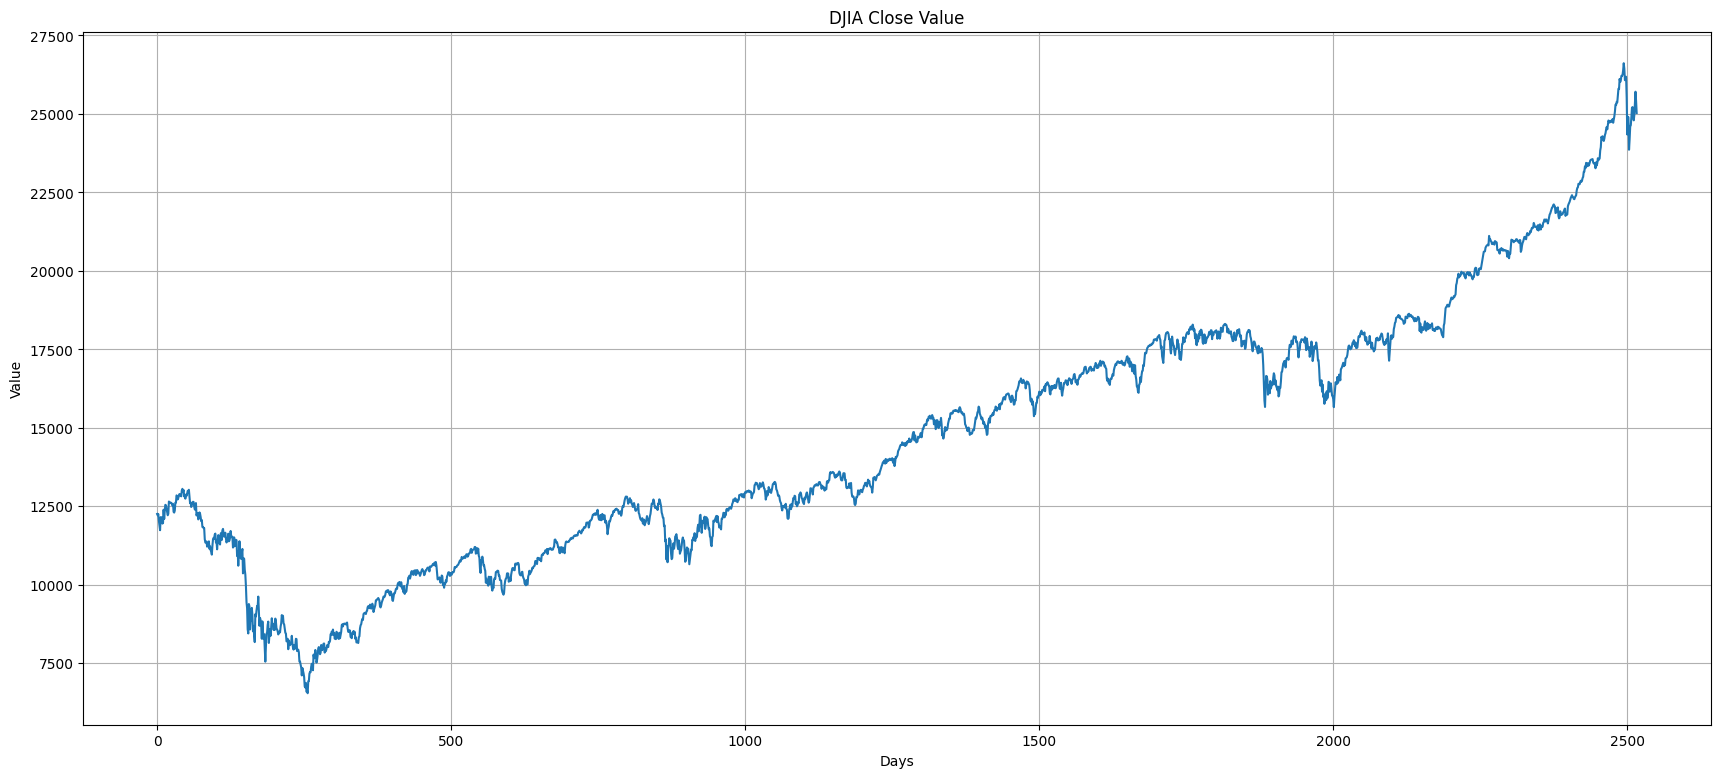

In [83]:
plt.figure(figsize=(21, 9))
plt.plot(close_values)
plt.title('DJIA Close Value')
plt.xlabel('Days')
plt.ylabel('Value')
plt.grid()
plt.show()

In [38]:
class NeoFuzzyNeuron:
    def __init__(self, n_inputs, h_rules):
        self.n_inputs = n_inputs
        self.h_rules = h_rules
        self.weights = np.random.rand(h_rules, n_inputs + 1)

    def activation_function(self, x):
        return np.tanh(x)

    def fuzzy_inference(self, x):
        mu = np.zeros((self.h_rules, self.n_inputs + 1))
        min_inputs = min(self.n_inputs, len(x))
        x_range = np.arange(self.h_rules)

        for i in range(min_inputs):
            mu[:, i] = np.exp(-((x[i] - x_range) ** 2) / (2 * 1.0 ** 2))

        mu[:, -1] = 1
        return mu

    def forward(self, x):
        mu = self.fuzzy_inference(x)
        output = np.dot(self.weights.flatten(), mu.flatten())
        return self.activation_function(output)

    def update_weights(self, x, y, learning_rate):
        mu = self.fuzzy_inference(x)
        output = np.dot(self.weights.flatten(), mu.flatten())
        error = y - self.activation_function(output)
        self.weights += learning_rate * error * mu

In [39]:
class CascadeNeoFuzzyNetwork:
    def __init__(self, n_inputs, h_rules, initial_neurons=1, target_accuracy=0.01, patience=10):
        self.n_inputs = n_inputs
        self.h_rules = h_rules
        self.neurons = [NeoFuzzyNeuron(n_inputs + i, h_rules) for i in range(initial_neurons)]
        self.target_accuracy = target_accuracy
        self.best_loss = float('inf')
        self.patience = patience
        self.stagnation_count = 0

    def forward(self, x):
        outputs = np.zeros(len(self.neurons))
        for i in range(len(self.neurons)):
            if i == 0:
                outputs[i] = self.neurons[i].forward(x)
            else:
                combined_input = np.append(x, outputs[:i])
                outputs[i] = self.neurons[i].forward(combined_input)
        return outputs

    def train_neuron(self, neuron, x_train, y_train, learning_rate):
        for x, y in zip(x_train, y_train):
            neuron.update_weights(x, y, learning_rate)

    def train(self, x_train, y_train, epochs, learning_rate):
        print(f"Training model with {self.n_inputs} inputs and {self.h_rules} rules.\n")
        for epoch in tqdm(range(epochs), desc="Training Epochs"):
            outputs = np.zeros((len(x_train), len(self.neurons)))

            for i, neuron in enumerate(self.neurons):
                if i == 0:
                    self.train_neuron(neuron, x_train, y_train, learning_rate)
                else:
                    for j in range(i):
                        outputs[:, j] = [self.neurons[j].forward(x) for x in x_train]
                    combined_input = np.hstack((x_train, outputs[:, :i]))
                    self.train_neuron(neuron, combined_input, y_train, learning_rate)

            predictions = [self.forward(x)[-1] for x in x_train]
            avg_loss = np.sqrt(mean_squared_error(y_train, predictions))

            if avg_loss < self.target_accuracy:
                print('Target accuracy reached. Stopping training.')
                break

            if avg_loss < self.best_loss:
                self.best_loss = avg_loss
                self.stagnation_count = 0
            else:
                self.stagnation_count += 1
                if self.stagnation_count >= self.patience:
                    self.add_cascade()
                    self.stagnation_count = 0

        print('Num of cascades: ', len(self.neurons))

    def add_cascade(self):
        previous_weights = self.neurons[-1].weights
        new_cascade = NeoFuzzyNeuron(self.n_inputs + len(self.neurons), self.h_rules)
        new_cascade.weights[:, :-1] = previous_weights[:, :]
        self.neurons.append(new_cascade)
        self.best_loss = float('inf')

In [40]:
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        a = data[i:(i + look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

In [41]:
def train_test_split(data, look_back=10, split_size=0.78):
    X, y = create_dataset(data, look_back)

    train_size = ceil(len(X) * split_size)
    test_size = len(X) - train_size
    X_train, X_test = X[0:train_size], X[train_size:len(X)]
    y_train, y_test = y[0:train_size], y[train_size:len(y)]
    
    return X_train, X_test, y_train, y_test

In [42]:
def forecast_with_parameters_df(data, input_range, rule_range, n_neurons=4, epochs=200, learning_rate=0.001, accuracy=0.001, patience=10, split_size=0.78):
    df_results = pd.DataFrame()
    df_errors = pd.DataFrame(index=['MAE', 'MSE', 'RMSE'])
    df_errors_train = pd.DataFrame(index=['MAE', 'MSE', 'RMSE'])

    max_rows = 0
    max_rows_train = 0

    for n_inputs in input_range:
        X_train, X_test, y_train, y_test = train_test_split(data, n_inputs, split_size)

        for h_rules in rule_range:
            x_train, x_test, Y_train, Y_test = X_train, X_test, y_train, y_test
            model_name = f'CNFNN({n_inputs}, {h_rules})'

            cfnn = CascadeNeoFuzzyNetwork(n_inputs, h_rules, initial_neurons=n_neurons, target_accuracy=accuracy, patience=patience)
            cfnn.train(x_train, Y_train, epochs=epochs, learning_rate=learning_rate)

            train_predictions = []
            for x in x_train:
                train_predictions.append(cfnn.forward(x)[-1])

            test_predictions = []
            for x in x_test:
                test_predictions.append(cfnn.forward(x)[-1])

            train_predictions = np.array(train_predictions).reshape(-1, 1)
            train_predictions = scaler.inverse_transform(train_predictions)
            Y_train = Y_train.reshape(-1, 1)
            Y_train = scaler.inverse_transform(Y_train)

            test_predictions = np.array(test_predictions).reshape(-1, 1)
            test_predictions = scaler.inverse_transform(test_predictions)
            Y_test = Y_test.reshape(-1, 1)
            Y_test = scaler.inverse_transform(Y_test)

            tmae = mean_absolute_error(Y_train, train_predictions)
            tmse = mean_squared_error(Y_train, train_predictions)
            trmse = np.sqrt(tmse)

            mae = mean_absolute_error(Y_test, test_predictions)
            mse = mean_squared_error(Y_test, test_predictions)
            rmse = np.sqrt(mse)

            print(f'Train MAE: {tmae:.4f}, Train MSE: {tmse:.4f}, Train RMSE: {trmse:.4f}\nTest MAE: {mae:.4f}, Test MSE: {mse:.4f}, Test RMSE: {rmse:.4f}\n', '____________________________________________________________________________')

            max_rows_train = max(max_rows_train, len(train_predictions))
            while len(train_predictions) < max_rows_train:
                train_predictions = np.append(train_predictions, -999)

            max_rows = max(max_rows, len(test_predictions))
            while len(test_predictions) < max_rows:
                test_predictions = np.append(test_predictions, -999)

            df_results[model_name] = test_predictions.flatten()
            df_errors[model_name] = [mae, mse, rmse]
            df_errors_train[model_name] = [tmae, tmse, trmse]
            df_errors.set_index(df_errors.columns[0], inplace=True)
            df_errors_train.set_index(df_errors.columns[0], inplace=True)

    return df_results, df_errors, df_errors_train

In [44]:
input_range = range(4, 12)
rule_range = range(4, 12)
n_neurons = 1
accuracy = 0.0001
patience = 8
epochs = 220

df_results, df_errors, df_train_errors = forecast_with_parameters_df(close_values_scaled, input_range, rule_range, epochs=epochs, n_neurons=n_neurons, accuracy=accuracy, patience=patience)

Training model with 4 inputs and 4 rules.



Training Epochs: 100%|██████████| 220/220 [00:29<00:00,  7.52it/s]


Num of cascades:  1
Train MAE: 152.1225, Train MSE: 39003.4012, Train RMSE: 197.4928
Test MAE: 507.4592, Test MSE: 595949.9921, Test RMSE: 771.9780
 ____________________________________________________________________________
Training model with 4 inputs and 5 rules.



Training Epochs: 100%|██████████| 220/220 [00:28<00:00,  7.82it/s]


Num of cascades:  1
Train MAE: 174.7276, Train MSE: 53270.0887, Train RMSE: 230.8031
Test MAE: 794.5913, Test MSE: 1318916.0026, Test RMSE: 1148.4407
 ____________________________________________________________________________
Training model with 4 inputs and 6 rules.



Training Epochs: 100%|██████████| 220/220 [00:28<00:00,  7.86it/s]


Num of cascades:  1
Train MAE: 264.7830, Train MSE: 166658.0137, Train RMSE: 408.2377
Test MAE: 304.5590, Test MSE: 256741.1542, Test RMSE: 506.6963
 ____________________________________________________________________________
Training model with 4 inputs and 7 rules.



Training Epochs: 100%|██████████| 220/220 [00:28<00:00,  7.79it/s]


Num of cascades:  1
Train MAE: 153.5199, Train MSE: 49007.1746, Train RMSE: 221.3756
Test MAE: 468.2619, Test MSE: 512872.6667, Test RMSE: 716.1513
 ____________________________________________________________________________
Training model with 4 inputs and 8 rules.



Training Epochs: 100%|██████████| 220/220 [00:28<00:00,  7.84it/s]


Num of cascades:  1
Train MAE: 199.2234, Train MSE: 73634.0600, Train RMSE: 271.3560
Test MAE: 603.1397, Test MSE: 778692.1196, Test RMSE: 882.4353
 ____________________________________________________________________________
Training model with 4 inputs and 9 rules.



Training Epochs: 100%|██████████| 220/220 [00:28<00:00,  7.81it/s]


Num of cascades:  1
Train MAE: 240.5340, Train MSE: 132019.3146, Train RMSE: 363.3446
Test MAE: 427.0369, Test MSE: 437533.4574, Test RMSE: 661.4631
 ____________________________________________________________________________
Training model with 4 inputs and 10 rules.



Training Epochs: 100%|██████████| 220/220 [00:30<00:00,  7.23it/s]


Num of cascades:  1
Train MAE: 206.3442, Train MSE: 67350.0380, Train RMSE: 259.5189
Test MAE: 944.1955, Test MSE: 1752121.2002, Test RMSE: 1323.6772
 ____________________________________________________________________________
Training model with 4 inputs and 11 rules.



Training Epochs: 100%|██████████| 220/220 [01:15<00:00,  2.90it/s]


Num of cascades:  2
Train MAE: 485.7311, Train MSE: 471011.0992, Train RMSE: 686.3025
Test MAE: 368.0363, Test MSE: 189400.6363, Test RMSE: 435.2018
 ____________________________________________________________________________
Training model with 5 inputs and 4 rules.



Training Epochs: 100%|██████████| 220/220 [00:32<00:00,  6.79it/s]


Num of cascades:  1
Train MAE: 162.4547, Train MSE: 51242.2903, Train RMSE: 226.3676
Test MAE: 435.6794, Test MSE: 457656.7565, Test RMSE: 676.5033
 ____________________________________________________________________________
Training model with 5 inputs and 5 rules.



Training Epochs: 100%|██████████| 220/220 [00:42<00:00,  5.23it/s]


Num of cascades:  2
Train MAE: 438.1749, Train MSE: 462316.5923, Train RMSE: 679.9387
Test MAE: 287.3867, Test MSE: 236355.7787, Test RMSE: 486.1644
 ____________________________________________________________________________
Training model with 5 inputs and 6 rules.



Training Epochs: 100%|██████████| 220/220 [00:35<00:00,  6.23it/s]


Num of cascades:  2
Train MAE: 1461.4779, Train MSE: 3852768.5236, Train RMSE: 1962.8470
Test MAE: 440.4711, Test MSE: 392710.7438, Test RMSE: 626.6664
 ____________________________________________________________________________
Training model with 5 inputs and 7 rules.



Training Epochs: 100%|██████████| 220/220 [00:32<00:00,  6.72it/s]


Num of cascades:  1
Train MAE: 232.4908, Train MSE: 90526.8721, Train RMSE: 300.8768
Test MAE: 715.6624, Test MSE: 1066956.9098, Test RMSE: 1032.9361
 ____________________________________________________________________________
Training model with 5 inputs and 8 rules.



Training Epochs: 100%|██████████| 220/220 [00:40<00:00,  5.42it/s]


Num of cascades:  2
Train MAE: 442.8573, Train MSE: 290456.3300, Train RMSE: 538.9400
Test MAE: 325.2441, Test MSE: 184028.4014, Test RMSE: 428.9853
 ____________________________________________________________________________
Training model with 5 inputs and 9 rules.



Training Epochs: 100%|██████████| 220/220 [00:39<00:00,  5.64it/s]


Num of cascades:  2
Train MAE: 982.4047, Train MSE: 2107776.2006, Train RMSE: 1451.8182
Test MAE: 231.4238, Test MSE: 133027.7830, Test RMSE: 364.7297
 ____________________________________________________________________________
Training model with 5 inputs and 10 rules.



Training Epochs: 100%|██████████| 220/220 [00:32<00:00,  6.73it/s]


Num of cascades:  1
Train MAE: 156.6847, Train MSE: 41225.7931, Train RMSE: 203.0414
Test MAE: 412.3329, Test MSE: 413404.6332, Test RMSE: 642.9655
 ____________________________________________________________________________
Training model with 5 inputs and 11 rules.



Training Epochs: 100%|██████████| 220/220 [00:32<00:00,  6.72it/s]


Num of cascades:  1
Train MAE: 264.8971, Train MSE: 106389.3195, Train RMSE: 326.1738
Test MAE: 538.3064, Test MSE: 645602.6145, Test RMSE: 803.4940
 ____________________________________________________________________________
Training model with 6 inputs and 4 rules.



Training Epochs: 100%|██████████| 220/220 [00:39<00:00,  5.58it/s]


Num of cascades:  2
Train MAE: 1323.5663, Train MSE: 3043125.6467, Train RMSE: 1744.4557
Test MAE: 388.8093, Test MSE: 293490.6810, Test RMSE: 541.7478
 ____________________________________________________________________________
Training model with 6 inputs and 5 rules.



Training Epochs: 100%|██████████| 220/220 [00:47<00:00,  4.67it/s]


Num of cascades:  2
Train MAE: 999.9381, Train MSE: 1766152.8264, Train RMSE: 1328.9668
Test MAE: 411.5136, Test MSE: 352444.6297, Test RMSE: 593.6705
 ____________________________________________________________________________
Training model with 6 inputs and 6 rules.



Training Epochs: 100%|██████████| 220/220 [00:37<00:00,  5.92it/s]


Num of cascades:  1
Train MAE: 216.2226, Train MSE: 89585.6262, Train RMSE: 299.3086
Test MAE: 623.1421, Test MSE: 779557.1440, Test RMSE: 882.9253
 ____________________________________________________________________________
Training model with 6 inputs and 7 rules.



Training Epochs: 100%|██████████| 220/220 [00:36<00:00,  5.97it/s]


Num of cascades:  1
Train MAE: 314.4482, Train MSE: 196533.5297, Train RMSE: 443.3210
Test MAE: 426.1544, Test MSE: 397172.4273, Test RMSE: 630.2162
 ____________________________________________________________________________
Training model with 6 inputs and 8 rules.



Training Epochs: 100%|██████████| 220/220 [00:48<00:00,  4.51it/s]


Num of cascades:  2
Train MAE: 730.4969, Train MSE: 1110704.2770, Train RMSE: 1053.8996
Test MAE: 280.8804, Test MSE: 211760.8105, Test RMSE: 460.1748
 ____________________________________________________________________________
Training model with 6 inputs and 9 rules.



Training Epochs: 100%|██████████| 220/220 [00:37<00:00,  5.91it/s]


Num of cascades:  1
Train MAE: 259.4760, Train MSE: 102590.0893, Train RMSE: 320.2969
Test MAE: 287.7775, Test MSE: 221808.4642, Test RMSE: 470.9655
 ____________________________________________________________________________
Training model with 6 inputs and 10 rules.



Training Epochs: 100%|██████████| 220/220 [00:38<00:00,  5.75it/s]


Num of cascades:  1
Train MAE: 269.6061, Train MSE: 130872.0676, Train RMSE: 361.7624
Test MAE: 514.2149, Test MSE: 551725.3331, Test RMSE: 742.7822
 ____________________________________________________________________________
Training model with 6 inputs and 11 rules.



Training Epochs: 100%|██████████| 220/220 [00:56<00:00,  3.89it/s]


Num of cascades:  2
Train MAE: 444.3868, Train MSE: 522865.5589, Train RMSE: 723.0944
Test MAE: 259.9394, Test MSE: 140197.0348, Test RMSE: 374.4289
 ____________________________________________________________________________
Training model with 7 inputs and 4 rules.



Training Epochs: 100%|██████████| 220/220 [00:49<00:00,  4.44it/s]


Num of cascades:  2
Train MAE: 575.5435, Train MSE: 782799.4576, Train RMSE: 884.7595
Test MAE: 284.9386, Test MSE: 204969.0514, Test RMSE: 452.7351
 ____________________________________________________________________________
Training model with 7 inputs and 5 rules.



Training Epochs: 100%|██████████| 220/220 [00:49<00:00,  4.47it/s]


Num of cascades:  3
Train MAE: 2668.2378, Train MSE: 8304407.3551, Train RMSE: 2881.7369
Test MAE: 606.7873, Test MSE: 552334.4979, Test RMSE: 743.1921
 ____________________________________________________________________________
Training model with 7 inputs and 6 rules.



Training Epochs: 100%|██████████| 220/220 [00:50<00:00,  4.36it/s]


Num of cascades:  2
Train MAE: 774.3300, Train MSE: 1363136.4270, Train RMSE: 1167.5343
Test MAE: 263.6891, Test MSE: 126011.2988, Test RMSE: 354.9807
 ____________________________________________________________________________
Training model with 7 inputs and 7 rules.



Training Epochs: 100%|██████████| 220/220 [01:04<00:00,  3.41it/s]


Num of cascades:  2
Train MAE: 490.1856, Train MSE: 385456.6202, Train RMSE: 620.8515
Test MAE: 407.2711, Test MSE: 228285.5513, Test RMSE: 477.7924
 ____________________________________________________________________________
Training model with 7 inputs and 8 rules.



Training Epochs: 100%|██████████| 220/220 [00:53<00:00,  4.14it/s]


Num of cascades:  2
Train MAE: 497.7715, Train MSE: 596540.6718, Train RMSE: 772.3605
Test MAE: 260.0767, Test MSE: 149409.3411, Test RMSE: 386.5350
 ____________________________________________________________________________
Training model with 7 inputs and 9 rules.



Training Epochs: 100%|██████████| 220/220 [01:00<00:00,  3.61it/s]


Num of cascades:  2
Train MAE: 671.0257, Train MSE: 1034331.9345, Train RMSE: 1017.0211
Test MAE: 256.5802, Test MSE: 133438.3843, Test RMSE: 365.2922
 ____________________________________________________________________________
Training model with 7 inputs and 10 rules.



Training Epochs: 100%|██████████| 220/220 [00:39<00:00,  5.53it/s]


Num of cascades:  1
Train MAE: 356.6859, Train MSE: 280742.5340, Train RMSE: 529.8514
Test MAE: 277.2230, Test MSE: 171455.9212, Test RMSE: 414.0724
 ____________________________________________________________________________
Training model with 7 inputs and 11 rules.



Training Epochs: 100%|██████████| 220/220 [00:50<00:00,  4.32it/s]


Num of cascades:  3
Train MAE: 1041.4523, Train MSE: 1423510.3321, Train RMSE: 1193.1095
Test MAE: 485.9771, Test MSE: 336382.0143, Test RMSE: 579.9845
 ____________________________________________________________________________
Training model with 8 inputs and 4 rules.



Training Epochs: 100%|██████████| 220/220 [00:45<00:00,  4.86it/s]


Num of cascades:  1
Train MAE: 162.4329, Train MSE: 48703.8753, Train RMSE: 220.6895
Test MAE: 550.5448, Test MSE: 638165.8687, Test RMSE: 798.8528
 ____________________________________________________________________________
Training model with 8 inputs and 5 rules.



Training Epochs: 100%|██████████| 220/220 [00:47<00:00,  4.67it/s]


Num of cascades:  1
Train MAE: 352.1635, Train MSE: 200860.2273, Train RMSE: 448.1743
Test MAE: 303.2390, Test MSE: 153833.4591, Test RMSE: 392.2161
 ____________________________________________________________________________
Training model with 8 inputs and 6 rules.



Training Epochs: 100%|██████████| 220/220 [00:53<00:00,  4.09it/s]


Num of cascades:  2
Train MAE: 1384.1004, Train MSE: 3368906.1593, Train RMSE: 1835.4580
Test MAE: 339.3176, Test MSE: 227084.1710, Test RMSE: 476.5335
 ____________________________________________________________________________
Training model with 8 inputs and 7 rules.



Training Epochs: 100%|██████████| 220/220 [00:47<00:00,  4.63it/s]


Num of cascades:  2
Train MAE: 1301.9384, Train MSE: 3679905.9563, Train RMSE: 1918.3081
Test MAE: 319.7323, Test MSE: 149701.2780, Test RMSE: 386.9125
 ____________________________________________________________________________
Training model with 8 inputs and 8 rules.



Training Epochs: 100%|██████████| 220/220 [01:01<00:00,  3.60it/s]


Num of cascades:  2
Train MAE: 1002.2444, Train MSE: 2128180.4718, Train RMSE: 1458.8285
Test MAE: 272.2878, Test MSE: 141419.9270, Test RMSE: 376.0584
 ____________________________________________________________________________
Training model with 8 inputs and 9 rules.



Training Epochs: 100%|██████████| 220/220 [00:46<00:00,  4.76it/s]


Num of cascades:  1
Train MAE: 327.4090, Train MSE: 161906.1553, Train RMSE: 402.3756
Test MAE: 285.1300, Test MSE: 152303.0692, Test RMSE: 390.2603
 ____________________________________________________________________________
Training model with 8 inputs and 10 rules.



Training Epochs: 100%|██████████| 220/220 [01:09<00:00,  3.15it/s]


Num of cascades:  2
Train MAE: 680.5228, Train MSE: 1138944.2763, Train RMSE: 1067.2133
Test MAE: 414.3398, Test MSE: 236442.8306, Test RMSE: 486.2539
 ____________________________________________________________________________
Training model with 8 inputs and 11 rules.



Training Epochs: 100%|██████████| 220/220 [01:06<00:00,  3.31it/s]


Num of cascades:  3
Train MAE: 1226.6041, Train MSE: 3787403.6126, Train RMSE: 1946.1253
Test MAE: 697.0885, Test MSE: 666310.5030, Test RMSE: 816.2784
 ____________________________________________________________________________
Training model with 9 inputs and 4 rules.



Training Epochs: 100%|██████████| 220/220 [00:54<00:00,  4.03it/s]


Num of cascades:  2
Train MAE: 1012.8671, Train MSE: 2001311.2549, Train RMSE: 1414.6771
Test MAE: 278.7249, Test MSE: 191624.9299, Test RMSE: 437.7498
 ____________________________________________________________________________
Training model with 9 inputs and 5 rules.



Training Epochs: 100%|██████████| 220/220 [01:03<00:00,  3.49it/s]


Num of cascades:  2
Train MAE: 1287.0075, Train MSE: 3240394.3370, Train RMSE: 1800.1095
Test MAE: 259.4257, Test MSE: 120444.6301, Test RMSE: 347.0513
 ____________________________________________________________________________
Training model with 9 inputs and 6 rules.



Training Epochs: 100%|██████████| 220/220 [01:09<00:00,  3.17it/s]


Num of cascades:  2
Train MAE: 697.6732, Train MSE: 1072535.7939, Train RMSE: 1035.6330
Test MAE: 676.7553, Test MSE: 636292.6730, Test RMSE: 797.6796
 ____________________________________________________________________________
Training model with 9 inputs and 7 rules.



Training Epochs: 100%|██████████| 220/220 [04:10<00:00,  1.14s/it]


Num of cascades:  3
Train MAE: 2277.0634, Train MSE: 6603276.5383, Train RMSE: 2569.6841
Test MAE: 1310.4754, Test MSE: 1875914.9479, Test RMSE: 1369.6404
 ____________________________________________________________________________
Training model with 9 inputs and 8 rules.



Training Epochs: 100%|██████████| 220/220 [01:03<00:00,  3.49it/s]


Num of cascades:  2
Train MAE: 866.3835, Train MSE: 1862339.5568, Train RMSE: 1364.6756
Test MAE: 383.8703, Test MSE: 204840.0406, Test RMSE: 452.5926
 ____________________________________________________________________________
Training model with 9 inputs and 9 rules.



Training Epochs: 100%|██████████| 220/220 [01:24<00:00,  2.60it/s]


Num of cascades:  2
Train MAE: 933.0523, Train MSE: 1938139.0455, Train RMSE: 1392.1706
Test MAE: 288.2293, Test MSE: 143108.7614, Test RMSE: 378.2972
 ____________________________________________________________________________
Training model with 9 inputs and 10 rules.



Training Epochs: 100%|██████████| 220/220 [00:54<00:00,  4.05it/s]


Num of cascades:  1
Train MAE: 296.3741, Train MSE: 122286.2783, Train RMSE: 349.6946
Test MAE: 275.4917, Test MSE: 198555.2439, Test RMSE: 445.5954
 ____________________________________________________________________________
Training model with 9 inputs and 11 rules.



Training Epochs: 100%|██████████| 220/220 [00:53<00:00,  4.13it/s]


Num of cascades:  1
Train MAE: 568.8085, Train MSE: 423181.5607, Train RMSE: 650.5241
Test MAE: 358.2328, Test MSE: 184597.9690, Test RMSE: 429.6487
 ____________________________________________________________________________
Training model with 10 inputs and 4 rules.



Training Epochs: 100%|██████████| 220/220 [01:19<00:00,  2.77it/s]


Num of cascades:  2
Train MAE: 826.3413, Train MSE: 990579.1241, Train RMSE: 995.2784
Test MAE: 764.3988, Test MSE: 797631.2851, Test RMSE: 893.1021
 ____________________________________________________________________________
Training model with 10 inputs and 5 rules.



Training Epochs: 100%|██████████| 220/220 [01:05<00:00,  3.38it/s]


Num of cascades:  2
Train MAE: 568.4009, Train MSE: 743381.5606, Train RMSE: 862.1958
Test MAE: 425.7992, Test MSE: 250048.0641, Test RMSE: 500.0481
 ____________________________________________________________________________
Training model with 10 inputs and 6 rules.



Training Epochs: 100%|██████████| 220/220 [01:44<00:00,  2.10it/s]


Num of cascades:  2
Train MAE: 1649.8052, Train MSE: 4981409.6096, Train RMSE: 2231.9072
Test MAE: 286.1257, Test MSE: 177969.0025, Test RMSE: 421.8637
 ____________________________________________________________________________
Training model with 10 inputs and 7 rules.



Training Epochs: 100%|██████████| 220/220 [04:24<00:00,  1.20s/it]


Num of cascades:  3
Train MAE: 1618.6129, Train MSE: 3365049.4887, Train RMSE: 1834.4071
Test MAE: 976.0865, Test MSE: 1339739.5545, Test RMSE: 1157.4712
 ____________________________________________________________________________
Training model with 10 inputs and 8 rules.



Training Epochs: 100%|██████████| 220/220 [02:05<00:00,  1.76it/s]


Num of cascades:  1
Train MAE: 281.4900, Train MSE: 112236.4932, Train RMSE: 335.0172
Test MAE: 263.6057, Test MSE: 156877.4017, Test RMSE: 396.0775
 ____________________________________________________________________________
Training model with 10 inputs and 9 rules.



Training Epochs: 100%|██████████| 220/220 [02:05<00:00,  1.76it/s]


Num of cascades:  1
Train MAE: 241.5950, Train MSE: 88294.1447, Train RMSE: 297.1433
Test MAE: 251.4400, Test MSE: 136133.2465, Test RMSE: 368.9624
 ____________________________________________________________________________
Training model with 10 inputs and 10 rules.



Training Epochs: 100%|██████████| 220/220 [02:04<00:00,  1.77it/s]


Num of cascades:  1
Train MAE: 361.6959, Train MSE: 191063.6869, Train RMSE: 437.1083
Test MAE: 290.9763, Test MSE: 157200.2753, Test RMSE: 396.4849
 ____________________________________________________________________________
Training model with 10 inputs and 11 rules.



Training Epochs: 100%|██████████| 220/220 [02:01<00:00,  1.81it/s]


Num of cascades:  1
Train MAE: 380.2865, Train MSE: 226863.5438, Train RMSE: 476.3019
Test MAE: 324.2811, Test MSE: 166331.0261, Test RMSE: 407.8370
 ____________________________________________________________________________
Training model with 11 inputs and 4 rules.



Training Epochs: 100%|██████████| 220/220 [03:23<00:00,  1.08it/s]


Num of cascades:  3
Train MAE: 590.0170, Train MSE: 566583.4992, Train RMSE: 752.7174
Test MAE: 310.2722, Test MSE: 175526.5288, Test RMSE: 418.9589
 ____________________________________________________________________________
Training model with 11 inputs and 5 rules.



Training Epochs: 100%|██████████| 220/220 [03:08<00:00,  1.17it/s]


Num of cascades:  2
Train MAE: 694.9592, Train MSE: 1079253.3105, Train RMSE: 1038.8712
Test MAE: 317.0529, Test MSE: 171572.9335, Test RMSE: 414.2136
 ____________________________________________________________________________
Training model with 11 inputs and 6 rules.



Training Epochs: 100%|██████████| 220/220 [03:49<00:00,  1.04s/it]


Num of cascades:  3
Train MAE: 765.6315, Train MSE: 1365451.9898, Train RMSE: 1168.5256
Test MAE: 570.7063, Test MSE: 441739.1370, Test RMSE: 664.6346
 ____________________________________________________________________________
Training model with 11 inputs and 7 rules.



Training Epochs: 100%|██████████| 220/220 [03:01<00:00,  1.21it/s]


Num of cascades:  2
Train MAE: 758.1397, Train MSE: 1386801.4032, Train RMSE: 1177.6253
Test MAE: 381.2698, Test MSE: 205459.8092, Test RMSE: 453.2767
 ____________________________________________________________________________
Training model with 11 inputs and 8 rules.



Training Epochs: 100%|██████████| 220/220 [02:02<00:00,  1.80it/s]


Num of cascades:  2
Train MAE: 996.1192, Train MSE: 2225489.8103, Train RMSE: 1491.8076
Test MAE: 322.6852, Test MSE: 156578.6376, Test RMSE: 395.7002
 ____________________________________________________________________________
Training model with 11 inputs and 9 rules.



Training Epochs: 100%|██████████| 220/220 [01:40<00:00,  2.18it/s]


Num of cascades:  1
Train MAE: 405.7755, Train MSE: 235944.8417, Train RMSE: 485.7415
Test MAE: 359.6808, Test MSE: 190334.5896, Test RMSE: 436.2735
 ____________________________________________________________________________
Training model with 11 inputs and 10 rules.



Training Epochs: 100%|██████████| 220/220 [01:03<00:00,  3.47it/s]


Num of cascades:  1
Train MAE: 344.3307, Train MSE: 180054.0539, Train RMSE: 424.3278
Test MAE: 327.6991, Test MSE: 189219.9847, Test RMSE: 434.9942
 ____________________________________________________________________________
Training model with 11 inputs and 11 rules.



Training Epochs: 100%|██████████| 220/220 [02:15<00:00,  1.63it/s]


Num of cascades:  2
Train MAE: 746.3856, Train MSE: 1340558.3367, Train RMSE: 1157.8248
Test MAE: 540.3551, Test MSE: 395379.1526, Test RMSE: 628.7918
 ____________________________________________________________________________


In [69]:
df_results.to_csv('all_predictions.csv', index=False)
df_errors.to_csv('all_errors.csv')

In [78]:
best_models = df_errors.idxmin(axis=1)

best_model_table = pd.DataFrame(index=['MAE', 'MSE', 'RMSE'], columns=['Best Model', 'MAE', 'MSE', 'RMSE'])

for metric in ['MAE', 'MSE', 'RMSE']:
    best_model_name = best_models[metric]
    best_model_table.at[metric, 'Best Model'] = best_model_name
    best_model_table.at[metric, 'MAE'] = df_errors.loc['MAE', best_model_name]
    best_model_table.at[metric, 'MSE'] = df_errors.loc['MSE', best_model_name]
    best_model_table.at[metric, 'RMSE'] = df_errors.loc['RMSE', best_model_name]

print("Models with best metrics value:")
print(best_model_table)

Таблиця з найкращими моделями за кожною метрикою:


,Best Model,MAE,MSE,RMSE
MAE,"CNFNN(5, 9)",231.423839,133027.783026,364.72974
MSE,"CNFNN(9, 5)",259.425717,120444.630149,347.051336
RMSE,"CNFNN(9, 5)",259.425717,120444.630149,347.051336


In [87]:
def best_model_by_metric(df, metric):
    if not (metric == 'MAE' or metric == 'MSE' or metric == 'RMSE'):
        print(f'Unknown metric {metric}')
        return
    best_model = df_errors.loc[metric].idxmin()
    print(f'Best model: {best_model} with {metric} = {df_errors.loc[metric, best_model]:.4f}')
    df_best_model = df_results[best_model].replace(-999, np.nan).dropna(axis=0, how='all')

    plt.figure(figsize=(21, 9))
    plt.plot(df_best_model.index, scaler.inverse_transform(close_values_scaled[len(close_values_scaled) - len(df_best_model.index):]), label='Actual Values')
    plt.plot(df_best_model.index, df_best_model.values, label='Predicted Values')
    plt.title(f'DJIA Value Prediction using {best_model}')
    plt.xlabel('Days')
    plt.ylabel('Value')
    plt.grid()
    plt.legend()
    plt.show()

Best model: CNFNN(5, 9) with MAE = 231.4238


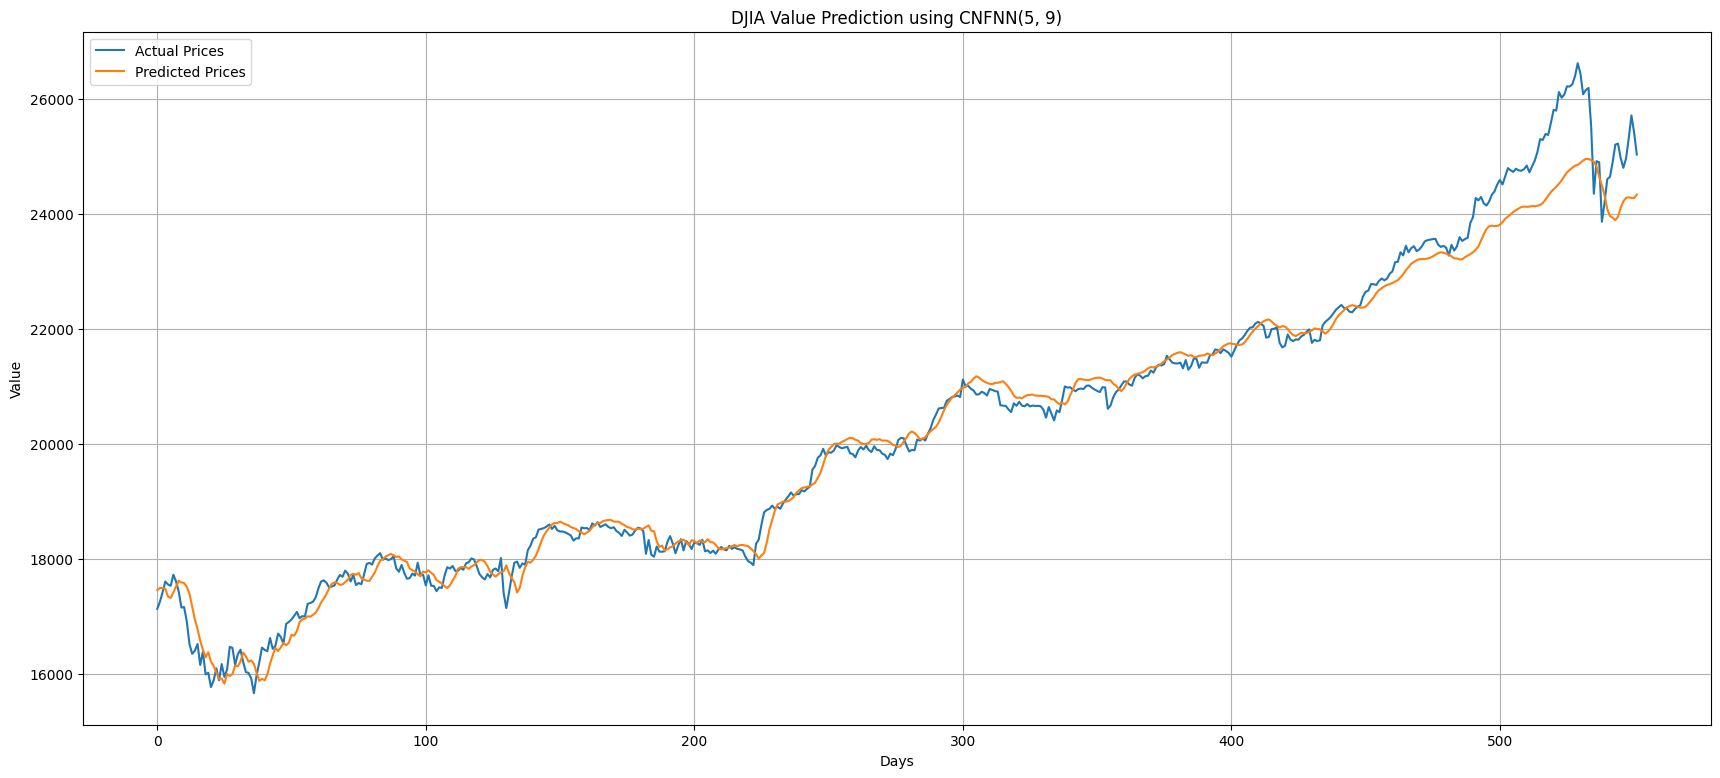

In [88]:
best_model_by_metric(df_errors, 'MAE')

In [61]:
def analyze_metric(df, metric_name, parameter):
    if metric_name not in df.index:
        raise ValueError(f"There is no row for {metric_name} in dataframe")

    if parameter == "inputs":
        param_index = 0
    elif parameter == "rules":
        param_index = 1
    else:
        raise ValueError("parameter has to be \"inputs\" or \"rules\".")

    param_values = []
    metric_values = []
    
    for col in df.columns:
        params = col.split('(')[1].split(')')[0].split(',')
        param_value = int(params[param_index])
        param_values.append(param_value)
        metric_values.append(df.loc[metric_name, col])
    
    analysis_df = pd.DataFrame({parameter: param_values, metric_name: metric_values})
    
    mean_values = analysis_df.groupby(parameter)[metric_name].mean().reset_index()

    # Візуалізація результатів
    plt.figure(figsize=(10, 6))
    plt.plot(mean_values[parameter], mean_values[metric_name], marker='o')
    plt.title(f'Mean value of {metric_name} depending on the number of {parameter}')
    plt.xlabel(parameter)
    plt.ylabel(metric_name)
    plt.grid(True)
    plt.show()

    return mean_values

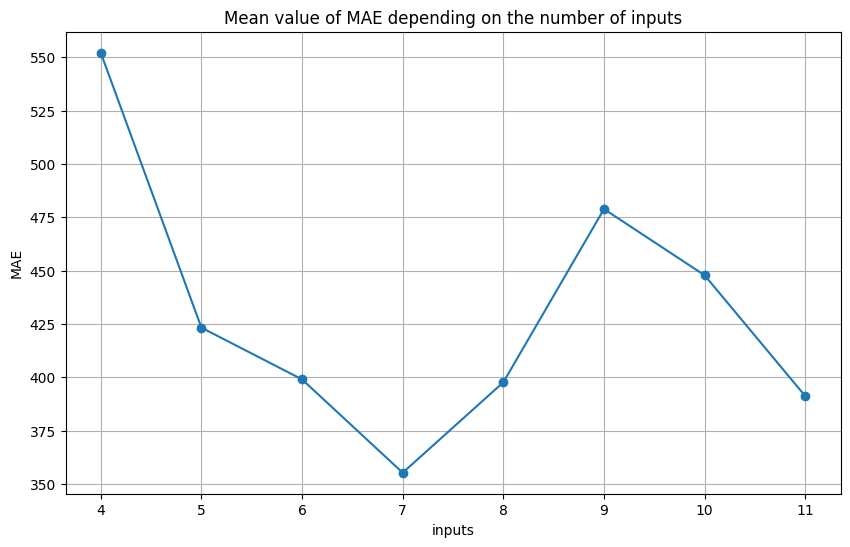

,inputs,MAE
0,4,552.159983
1,5,423.313364
2,6,399.053955
3,7,355.317891
4,8,397.709972
5,9,478.900681
6,10,447.839169
7,11,391.215157


In [73]:
mean_inputs = analyze_metric(df_errors, "MAE", "inputs")
mean_inputs.head(8)

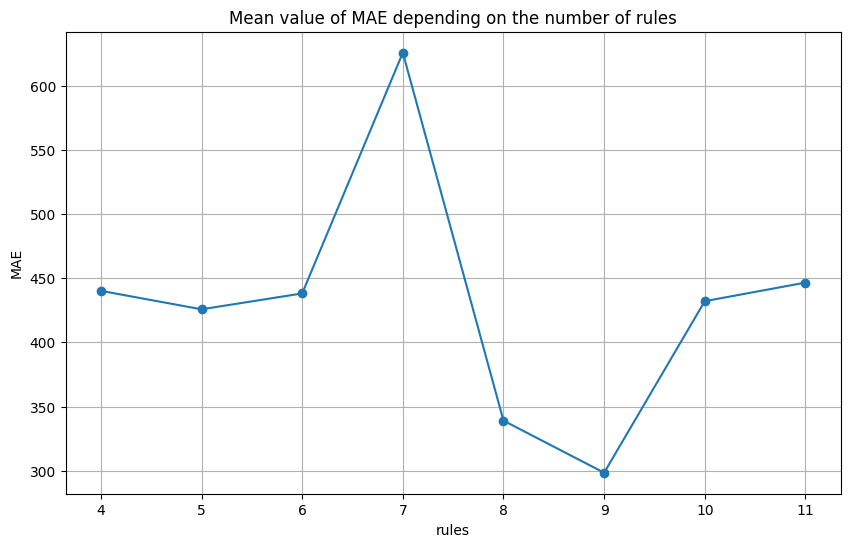

,rules,MAE
0,4,440.103406
1,5,425.724464
2,6,438.095773
3,7,625.614223
4,8,338.973736
5,9,298.412325
6,10,432.059147
7,11,446.527099


In [74]:
mean_rules = analyze_metric(df_errors, "MAE", "rules")
mean_rules.head(8)

In [79]:
import os

def create_excel_with_metrics(df, output_file):
    if os.path.exists(output_file):
        os.remove(output_file)
    models = df.columns
    parsed_models = [(int(m.split('(')[1].split(',')[0]), int(m.split(',')[1].split(')')[0])) for m in models]

    inputs = sorted(set([m[0] for m in parsed_models]))
    rules = sorted(set([m[1] for m in parsed_models]))

    metrics = ['MAE', 'MSE', 'RMSE']
    metric_dfs = {metric: pd.DataFrame(index=rules, columns=inputs) for metric in metrics}

    for metric in metrics:
        for (i, (n_inputs, n_rules)) in enumerate(parsed_models):
            metric_dfs[metric].loc[n_rules, n_inputs] = df.loc[metric, models[i]]
        metric_dfs[metric]['Hint'] = ["Columns - num of inputs"] + ["Rows - num of rules"] + [None] * (len(metric_dfs[metric]) - 2)
    with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
        for metric, df in metric_dfs.items():
            df.to_excel(writer, sheet_name=metric)

In [81]:
create_excel_with_metrics(df_errors, "all_errors.xlsx")